In [1]:
from utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import altair as alt

# Challenge

When utilizing Facebook data to monitor people's movement, one critical challenge is: how could we take the effect of power outage and signal lose into consideration?

# Some equations

Define $STAY(t)$ as people staying in the node city by the end of time window $t$.

2 fundamental equations:

$$STAY(t) = LOOP(t) + IN(t)$$

$$STAY(t) = LOOP(t+1) + OUT(t+1)$$

1 key equation - User balance equation:

$$IN(t) + LOOP(t) = OUT(t+1) + LOOP(t+1)$$

2 derived equations:

$$STAY(t+1) - STAY(t) =  IN(t+1) - OUT(t+1)$$

$$TOTAL(t+1) - TOTAL(t)  = IN(t+1) - OUT(t)$$

# Inconsistency

We may lose track of FB users. In a disaster scene, the reasons could be:

1. People lose power due to power grid failure.
2. People lose signal due to signal tower failure.
3. People lose power or turn off location tracking service to save battery when they evacuate.
4. Other random daily events.

## Marginal inconsistency and cumulative inconsistency

$$MarginalInconsistency (MI) = OUT(t+1) + LOOP(t+1) - IN(t) - LOOP(t)$$

$MI$ equals the number of people who **we fail to detect by the end of time window $t$ but resume tracking during time window $t+1$** minus the number of people who **we detect by the end of time window $t$ but lose track of during time window $t+1$** .

By taking the cumulative sum of $MI$, we get the cumulative inconsistency($CI$).
$$CI = \sum_{t=0}^{T-1}OUT(t+1) + \sum_{t=0}^{T-1}LOOP(t+1) - \sum_{t=0}^{T-1}IN(t) - \sum_{t=0}^{T-1}LOOP(t) \\ = \sum_{t=1}^{T}OUT(t) + \sum_{t=1}^{T}LOOP(t) - \sum_{t=0}^{T-1}IN(t) - \sum_{t=0}^{T-1}LOOP(t) \\ = OUT(T) - IN(0) + \sum_{t=1}^{T-1}NETOUT(t) + LOOP(T) - LOOP(0)$$

Note that:
1. people who were not detected since the beginning but suddenly appeared tend to bring the final $CI$ above $0$. 2 examples are FB users who did not enable location service before turning on the service to either mark themselves safe or ask for help and FB users who returned to the city with their location service off turning on the service after settling down.
2. people who were initially detected but were not regained track of towards the end of the period FB provides tend to drag the final $CI$ below $0$. An example is people who have not returned home by the end of the period in Facebook's data.

## Noise

The inconsistency caused by raondom noise is reflected by baseline inconsistency. This could be modeled as a 0-centered normally distributed noise.

Problem: will the randomness caused by daily events change during disasters?

Errors from NA filling (location estimation):
1. Radius-derived location
2. Arrow(lon-lat)-derived location
3. Redundancy

## Decouple
1. Pre-disaster: Assume no infrastructure damage, inconsistency due to Reason 3.
2. During Hurricane Florence: Assume no evacuation, inconsistency due to Reason 1 and 2.
3. Post-disaster: Hard to decouple. Assume no evacuation, inconsistency due to Reason 1 and 2.

In [2]:
time_span = ['sep_'+str(date)+'_'+hr for date in range(10, 31) for hr in ['00', '08', '16']] + ['oct_0'+str(date)+'_'+hr for date in range(1, 9) for hr in ['00', '08', '16']]

In [187]:
time_len = len(time_span)
df = pd.read_csv('cleansed_data/baseline_time_evolution_fillna/baseline_people_staying.csv', index_col=0)
for idx in df.index:
    for i in range(21):
        cycle = range(i, time_len, 21)
        series = df.loc[idx, list(np.array(time_span)[cycle])]
        if (series>=1).any():
            to_fill = series[series>=1].mean()
            df.loc[idx, list(np.array(time_span)[cycle])] = to_fill
    to_fill = df.loc[idx][df.loc[idx]>=1].mean()
    df.loc[idx][df.loc[idx]<1] = to_fill
df.to_csv('cleansed_data/baseline_time_evolution_fillna/baseline_loops.csv')

In [189]:
df=pd.read_csv('cleansed_data/baseline_time_evolution_fillna/baseline_loops.csv', index_col=0)
df.loc['Summerville_1'][df.loc['Summerville_1']<5000] = df.loc['Summerville_1'][df.loc['Summerville_1']>=5000].mean()
df.to_csv('cleansed_data/baseline_time_evolution_fillna/baseline_loops.csv')

In [190]:
df_in = pd.read_csv('cleansed_data/baseline_time_evolution_fillna/baseline_in_degree.csv', index_col=0)
df_loop = pd.read_csv('cleansed_data/baseline_time_evolution_fillna/baseline_loops.csv', index_col=0)
df_in_loop = df_in + df_loop
df_in_loop.to_csv('cleansed_data/baseline_time_evolution_fillna/baseline_in_degree_incl_loops.csv')

In [191]:
df_out = pd.read_csv('cleansed_data/baseline_time_evolution_fillna/baseline_out_degree.csv', index_col=0)
df_out_loop = df_out + df_loop
df_out_loop.to_csv('cleansed_data/baseline_time_evolution_fillna/baseline_out_degree_incl_loops.csv')

In [192]:
df_total = pd.read_csv('cleansed_data/baseline_time_evolution_fillna/baseline_total_degree.csv', index_col=0)
df_total_loop = df_total + df_loop
df_total_loop.to_csv('cleansed_data/baseline_time_evolution_fillna/baseline_total_degree_incl_loops.csv')

In [164]:
df = pd.read_csv('cleansed_data/crisis_time_evolution_fillna/crisis_people_staying.csv', index_col=0)
for idx in df.index:
    to_fill = df.loc[idx][df.loc[idx]>=1].mean()
    df.loc[idx][df.loc[idx]<1] = to_fill
df.to_csv('cleansed_data/crisis_time_evolution_fillna/crisis_loops.csv')

In [ ]:
df=pd.read_csv('cleansed_data/crisis_time_evolution_fillna/crisis_loops.csv', index_col=0)
df.loc['Summerville_1'][df.loc['Summerville_1']<5000] = df.loc['Summerville_1'][df.loc['Summerville_1']>=5000].mean()
df.to_csv('cleansed_data/crisis_time_evolution_fillna/crisis_loops.csv')

In [22]:
df_in = pd.read_csv('cleansed_data/crisis_time_evolution_fillna/crisis_in_degree.csv', index_col=0)
df_loop = pd.read_csv('cleansed_data/crisis_time_evolution_fillna/crisis_loops.csv', index_col=0)
df_in_loop = df_in + df_loop
df_in_loop.to_csv('cleansed_data/crisis_time_evolution_fillna/crisis_in_degree_incl_loops.csv')

In [23]:
df_out = pd.read_csv('cleansed_data/crisis_time_evolution_fillna/crisis_out_degree.csv', index_col=0)
df_out_loop = df_out + df_loop
df_out_loop.to_csv('cleansed_data/crisis_time_evolution_fillna/crisis_out_degree_incl_loops.csv')

In [24]:
df_total = pd.read_csv('cleansed_data/crisis_time_evolution_fillna/crisis_total_degree.csv', index_col=0)
df_total_loop = df_total + df_loop
df_total_loop.to_csv('cleansed_data/crisis_time_evolution_fillna/crisis_total_degree_incl_loops.csv')

In [13]:
evacuation = pd.read_csv('cleansed_data/evacuation.csv', index_col=0)

In [14]:
evacuation.head()

country     county state       lon  \
region name                                                              
Aaron_Bulloch County_Georgia            USA    Bulloch    GA -82.00970   
Abbeville_1                             USA  Abbeville    SC -82.38026   
Abbeville_5                             USA     Wilcox    GA -83.30692   
Abbotts Mill_Sussex County_Delaware     USA     Sussex    DE -75.46875   
Aberdeen_1                              USA      Brown    OH -83.76132   

                                          lat     evacuation  
region name                                                   
Aaron_Bulloch County_Georgia         32.55005  no evacuation  
Abbeville_1                          34.17896  no evacuation  
Abbeville_5                          31.99257  no evacuation  
Abbotts Mill_Sussex County_Delaware  38.88512  no evacuation  
Aberdeen_1                           38.65545  no evacuation

In [15]:
all_regions = list(evacuation.index)

In [16]:
mandatory = list(evacuation.index[(evacuation['evacuation']=='mandatory') & (evacuation['country']=='USA')])
voluntary = list(evacuation.index[evacuation['evacuation']=='voluntary'])
no_evacuation = list(evacuation.index[evacuation['evacuation']=='no evacuation'])
mandatory_cancel = list(evacuation.index[evacuation['evacuation'].str.contains('mandatory to')])

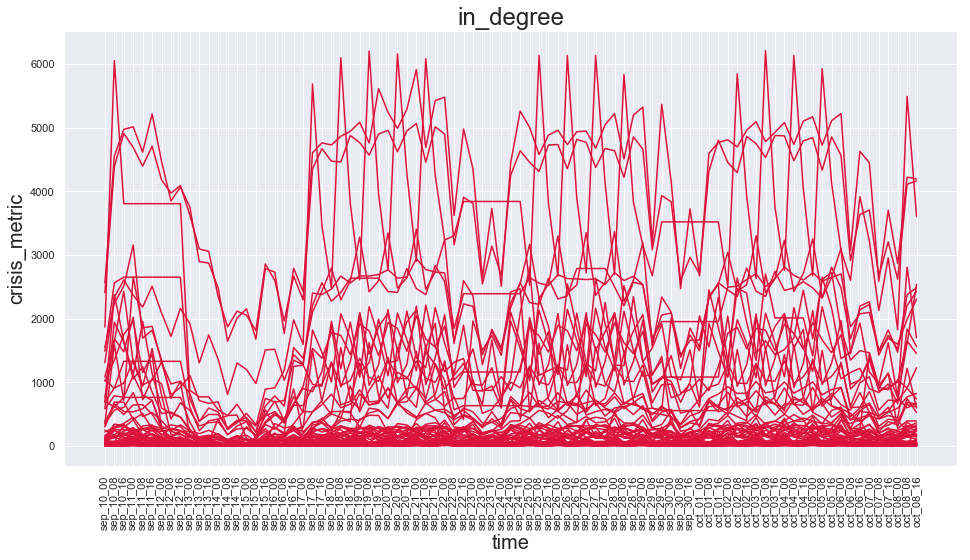

In [57]:
df = time_evolution(cities=mandatory, metric='in_degree', time_span=time_span, how='c', 
                    lower_bound=None, upper_bound=None, cut_off_metric='in_degree', avoid_zero_division=1)
draw_time_evolution(df, 'in_degree', option='c')

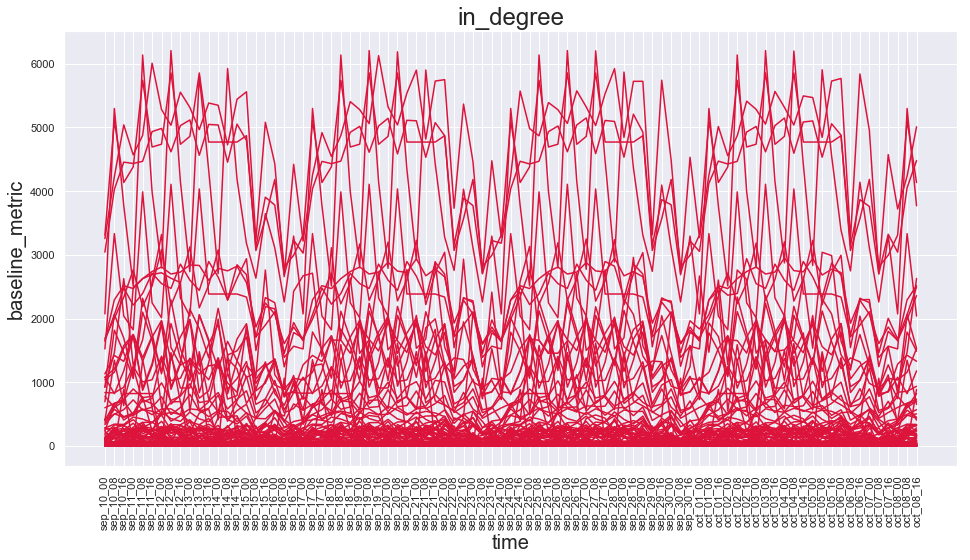

In [54]:
df = time_evolution(cities=mandatory, metric='in_degree', time_span=time_span, how='b', 
                    lower_bound=None, upper_bound=None, cut_off_metric='in_degree', avoid_zero_division=1)
draw_time_evolution(df, 'in_degree', option='b')

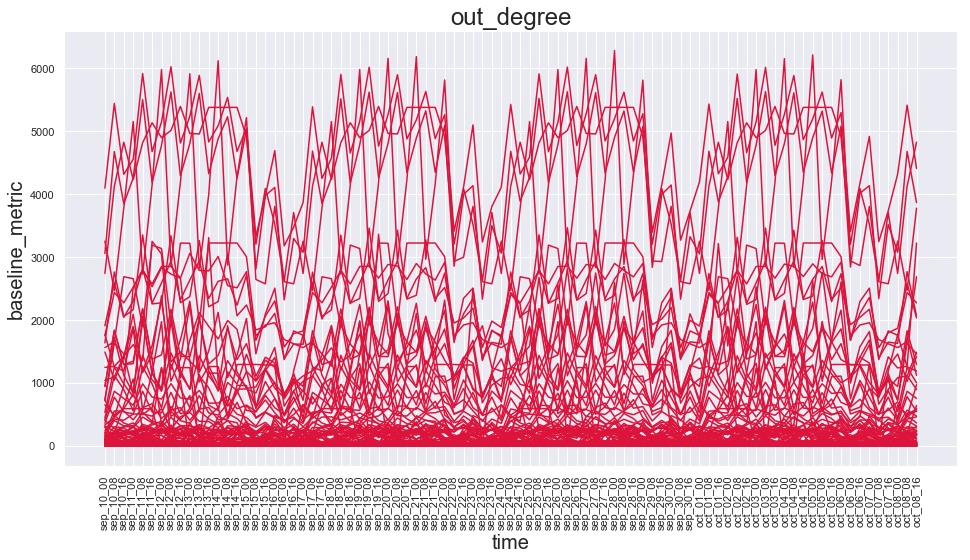

In [55]:
df = time_evolution(cities=mandatory, metric='out_degree', time_span=time_span, how='b', 
                    lower_bound=None, upper_bound=None, cut_off_metric='out_degree', avoid_zero_division=1)
draw_time_evolution(df, 'out_degree', option='b')

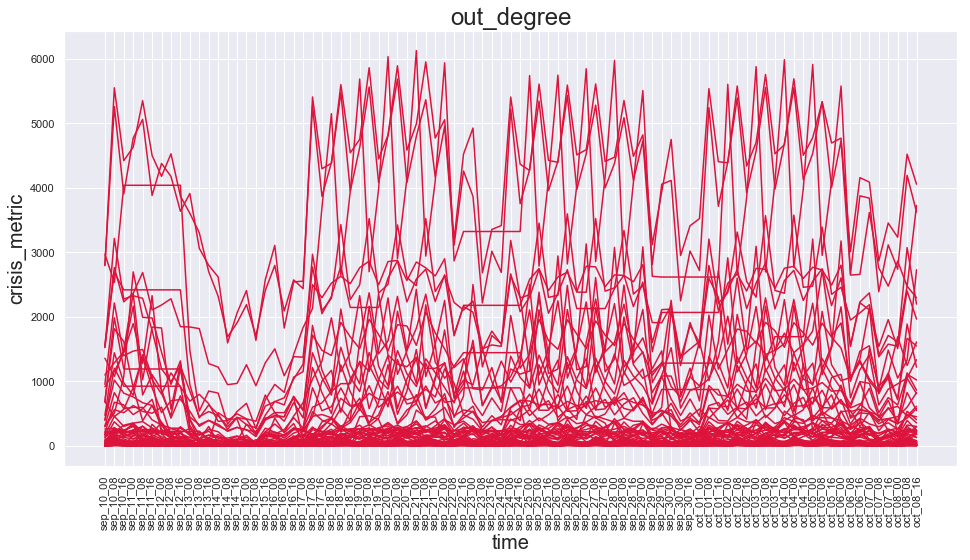

In [58]:
df = time_evolution(cities=mandatory, metric='out_degree', time_span=time_span, how='c', 
                    lower_bound=None, upper_bound=None, cut_off_metric='out_degree', avoid_zero_division=1)
draw_time_evolution(df, 'out_degree', option='c')

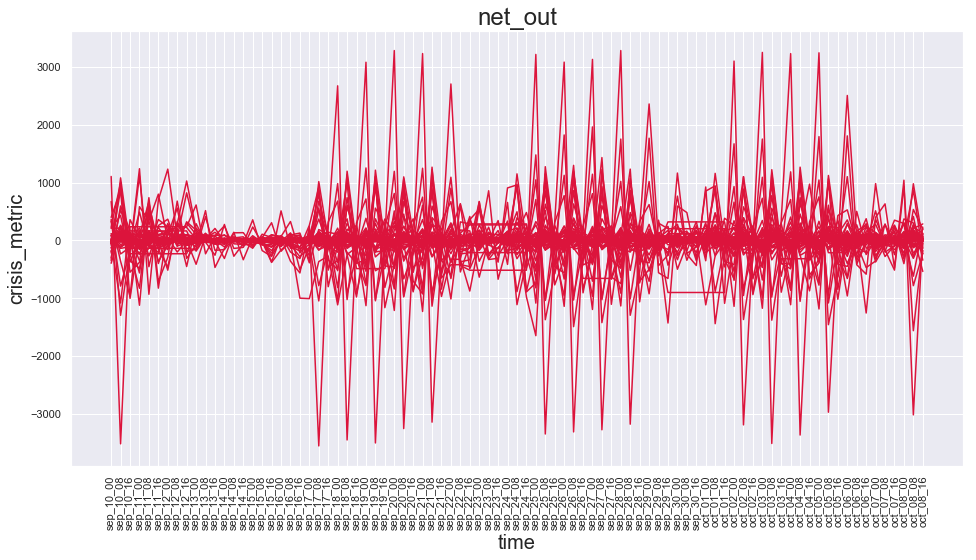

In [58]:
df_net_out = time_evolution(cities=mandatory, metric='out_degree', time_span=time_span, how='c', 
                    lower_bound=None, upper_bound=None, cut_off_metric='out_degree', avoid_zero_division=1).subtract( 
            time_evolution(cities=mandatory, metric='in_degree', time_span=time_span, how='c', 
                    lower_bound=None, upper_bound=None, cut_off_metric='in_degree', avoid_zero_division=1))
draw_time_evolution(df_net_out, 'net_out', option='c')

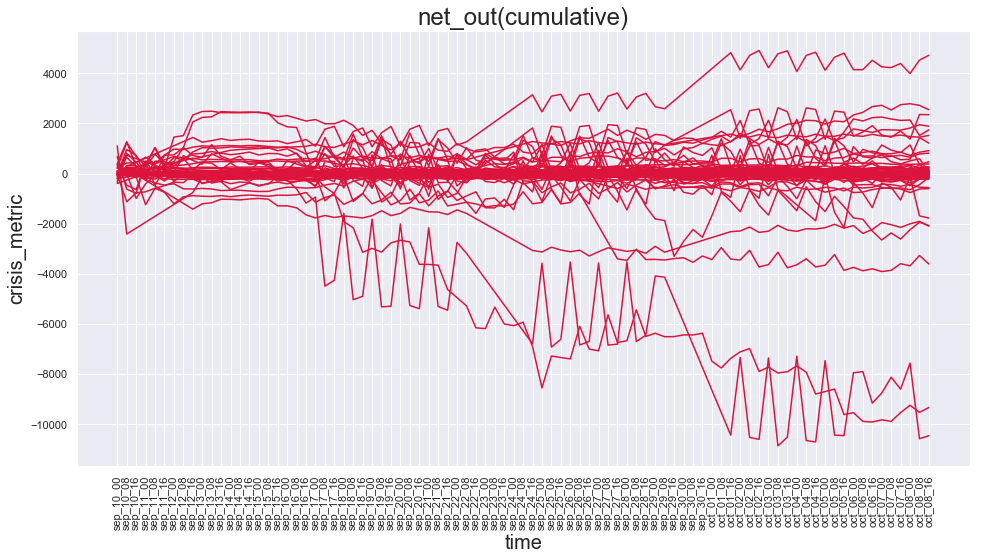

In [59]:
draw_time_evolution(df_net_out.cumsum(axis=1), 'net_out(cumulative)', option='c')

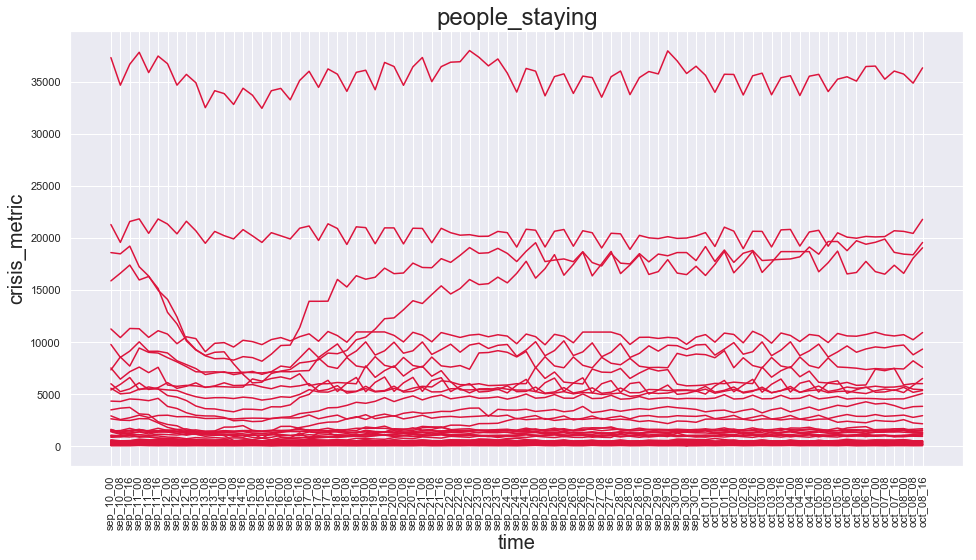

In [194]:
df_stay = time_evolution(cities=mandatory, metric='in_degree_incl_loops', time_span=time_span, how='c', 
                    lower_bound=None, upper_bound=None, cut_off_metric='in_degree_incl_loops', avoid_zero_division=1)
draw_time_evolution(df_stay, 'people_staying', option='c')

In [197]:
df_in_incl_loop = time_evolution(cities=mandatory, metric='in_degree_incl_loops', time_span=time_span, how='c', 
                    lower_bound=None, upper_bound=None, cut_off_metric='in_degree_incl_loops', avoid_zero_division=1)

In [198]:
df_out_incl_loop = time_evolution(cities=mandatory, metric='out_degree_incl_loops', time_span=time_span, how='c', 
                    lower_bound=None, upper_bound=None, cut_off_metric='out_degree_incl_loops', avoid_zero_division=1)

In [261]:
df_inconsistency = pd.DataFrame()

for i in range(1, len(time_span)):
    df_inconsistency[time_span[i]] = df_out_incl_loop[time_span[i]] - df_in_incl_loop[time_span[i-1]]

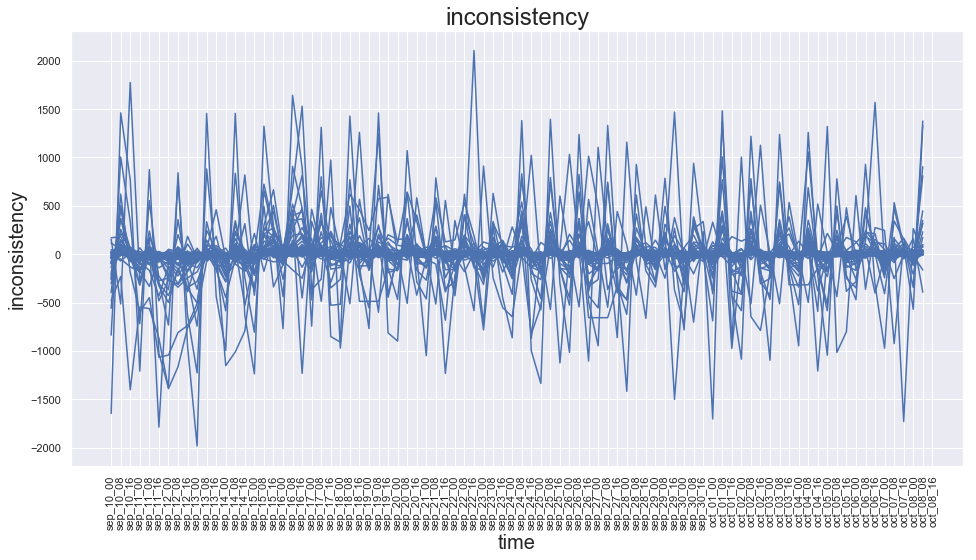

In [201]:
plt.figure(figsize=(16,8))
for i in df_inconsistency.index:
    if pd.isnull(df_inconsistency.loc[i]).any()==False:
        plt.plot(time_span[1:], df_inconsistency.loc[i], color='b')
plt.xticks(range(len(time_span)), time_span, rotation=90)
plt.xlabel('time', size=20)
plt.ylabel('inconsistency', size=20)
plt.title('inconsistency', size=24)
plt.show()

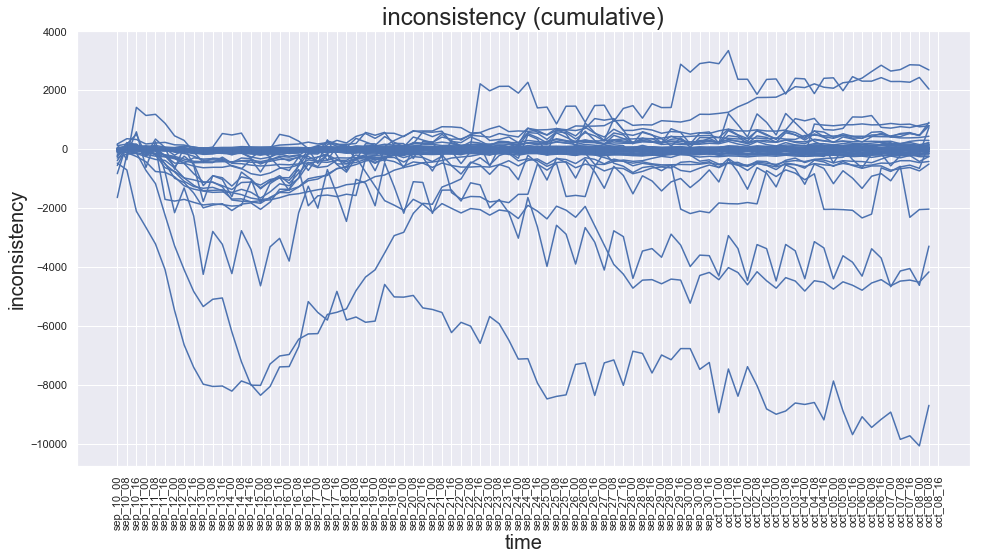

In [202]:
plt.figure(figsize=(16,8))
for i in df_inconsistency.index:
    if pd.isnull(df_inconsistency.cumsum(axis=1).loc[i]).any()==False:
        plt.plot(time_span[1:], df_inconsistency.cumsum(axis=1).loc[i], color='b')
plt.xticks(range(len(time_span)), time_span, rotation=90)
plt.xlabel('time', size=20)
plt.ylabel('inconsistency', size=20)
plt.title('inconsistency (cumulative)', size=24)
plt.show()

In [262]:
df_inconsistency[df_inconsistency.min(axis=1)<-2000]

sep_10_08  sep_10_16  sep_11_00  sep_11_08  sep_11_16  \
Charleston_2      154.0     -515.0     1775.5     -276.0       39.0   

              sep_12_00  sep_12_08  sep_12_16  sep_13_00  sep_13_08  \
Charleston_2     -303.0     -428.0     -153.0     -388.5      -56.0   

                ...      oct_05_16  oct_06_00  oct_06_08  oct_06_16  \
Charleston_2    ...         -440.0      479.0     -152.0       -1.0   

              oct_07_00  oct_07_08  oct_07_16  oct_08_00  oct_08_08  oct_08_16  
Charleston_2      120.0     -132.0        1.0      -25.0      162.0     -393.0  

[1 rows x 86 columns]

In [204]:
df_inconsistency.cumsum(axis=1)[(df_inconsistency.cumsum(axis=1).max(axis=1)>2000)|(df_inconsistency.cumsum(axis=1).min(axis=1)<-2000)]

sep_10_08  sep_10_16  sep_11_00  sep_11_08  sep_11_16  \
Charleston_2            154.0     -361.0     1414.5     1138.5     1177.5   
Goose Creek_1          -263.0      105.0      167.0     -146.0     -164.0   
Hampton_5              -397.0      104.0       76.0     -245.0       -5.0   
Johns Island_2         -142.0       -6.0      158.0      322.0      486.0   
Kitty Hawk              169.0      350.0      323.0      171.0      203.0   
Myrtle Beach           -478.0     -709.0    -2111.0    -2659.0    -3222.0   
Norfolk_3              -887.0     -294.0      289.0      872.0     1455.0   
North Charleston_2     -273.0      234.0      470.0      706.0      942.0   
Summerville_1          -201.0      162.0      120.0      -70.0       79.0   
Summerville_3             NaN        NaN        NaN        NaN        NaN   
Virginia Beach_3      -1648.0     -187.0      583.0     -627.0      247.0   
Wilmington_2           -560.0       61.0     -129.0     -725.0    -1175.0   

                      sep_12_00    sep_12_08    sep_12_16    sep_13_00  \
Charleston_2         874.500000   446.500000   293.500000   -95.000000   
Goose Creek_1       -492.000000  -991.000000 -1139.000000 -1491.000000   
Hampton_5           -233.000000  -600.000000  -243.000000  -498.000000   
Johns Island_2              NaN          NaN          NaN          NaN   
Kitty Hawk           226.000000   142.000000   135.000000    61.000000   
Myrtle Beach       -4090.000000 -5481.000000 -6646.000000 -7408.000000   
Norfolk_3                   NaN          NaN          NaN          NaN   
North Charleston_2          NaN          NaN          NaN          NaN   
Summerville_1      -1709.439024 -1767.439024 -1709.439024 -1809.439024   
Summerville_3               NaN  -287.000000  -269.000000  -597.000000   
Virginia Beach_3    -780.000000 -2161.000000 -1319.000000 -2270.000000   
Wilmington_2       -2241.000000 -3285.000000 -4096.000000 -4834.000000   

                      sep_13_08     ...         oct_05_16    oct_06_00  \
Charleston_2        -151.000000     ...       1977.000000  2456.000000   
Goose Creek_1      -1996.000000     ...        411.000000   340.000000   
Hampton_5          -1242.000000     ...      -4507.000000 -4623.000000   
Johns Island_2       302.000000     ...       2879.000000  2885.000000   
Kitty Hawk            26.000000     ...       2250.000000  2289.000000   
Myrtle Beach       -7981.000000     ...      -8890.000000 -9693.000000   
Norfolk_3                   NaN     ...       9812.000000          NaN   
North Charleston_2   511.000000     ...      -1009.000000 -1197.000000   
Summerville_1      -1898.439024     ...      -2057.439024 -2080.439024   
Summerville_3       -991.000000     ...      -4534.000000 -4576.000000   
Virginia Beach_3   -4253.000000     ...      -3623.000000 -3842.000000   
Wilmington_2       -5346.000000     ...         25.000000  -359.000000   

                      oct_06_08    oct_06_16  oct_07_00  oct_07_08  oct_07_16  \
Charleston_2        2304.000000  2303.000000     2423.0     2291.0     2292.0   
Goose Creek_1        236.000000   418.000000      535.0      407.0      421.0   
Hampton_5          -4792.000000 -4547.000000    -4434.0    -4643.0    -4482.0   
Johns Island_2      2808.000000  2922.000000     2919.0     2899.0     2945.0   
Kitty Hawk          2407.000000  2630.000000     2843.0     2646.0     2695.0   
Myrtle Beach       -9086.000000 -9449.000000    -9174.0    -8929.0    -9854.0   
Norfolk_3                   NaN          NaN        NaN        NaN        NaN   
North Charleston_2 -1286.000000  -973.000000    -1106.0    -1563.0    -1575.0   
Summerville_1      -2338.439024 -2208.439024     -639.0     -761.0     -587.0   
Summerville_3      -4755.000000 -4672.000000    -4688.0    -4704.0    -4720.0   
Virginia Beach_3   -4314.000000 -3385.000000    -3700.0    -4673.0    -4140.0   
Wilmington_2        -642.000000  -163.000000     -162.0     -571.0     -228.0   

                      oct_08_00     oc

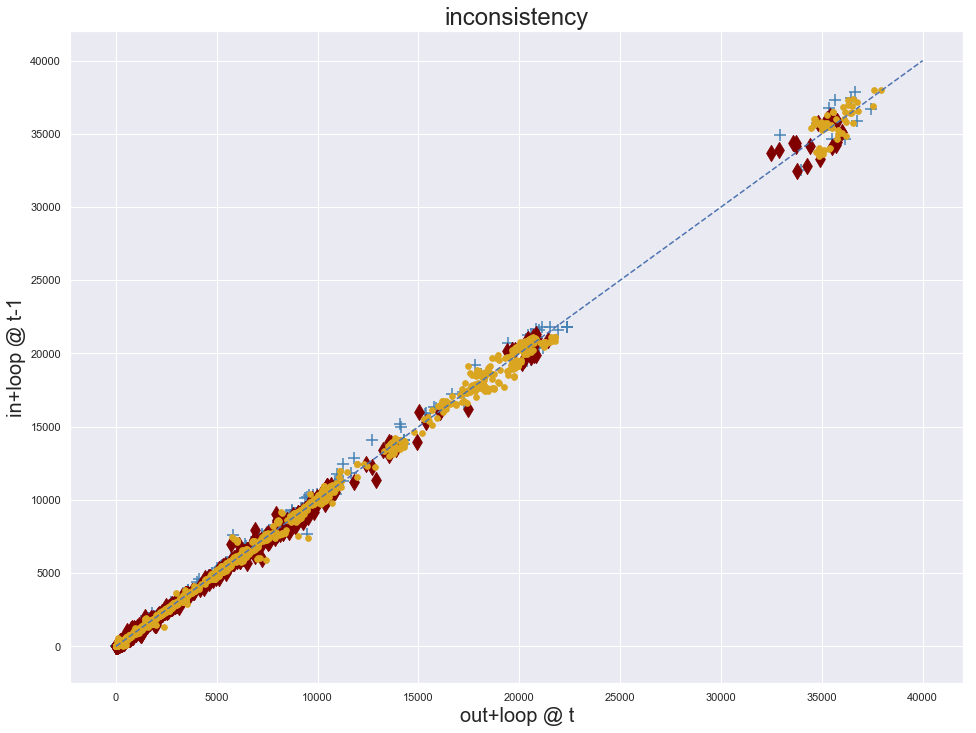

In [205]:
florence = ['sep_'+str(date)+'_'+hr for date in range(14, 20) for hr in ['00', '08', '16']]
before = ['sep_'+str(date)+'_'+hr for date in range(10, 14) for hr in ['00', '08', '16']]
plt.figure(figsize=(16,12))
shape={'before Florence':'+', 'during Florence':'d', 'after Florence':'.'}
color={'before Florence':'steelblue', 'during Florence':'maroon', 'after Florence':'goldenrod'}
for i in range(1, len(time_span)):
    if time_span[i] in florence:
        label='during Florence'
    elif time_span[i] in before:
        label='before Florence'
    else:
        label='after Florence'
    plt.scatter(df_out_incl_loop[time_span[i]], df_in_incl_loop[time_span[i-1]], marker=shape[label], s=128, color=color[label])
plt.plot([0, 40000], [0, 40000], '--')
plt.xlabel('out+loop @ t', size=20)
plt.ylabel('in+loop @ t-1', size=20)
plt.title('inconsistency', size=24)
#plt.legend(('+', 'd', '.d'), ('before Florence', 'during Florence', 'after Florence'))
plt.show()

In [206]:
df_in_incl_loop_b = time_evolution(cities=mandatory, metric='in_degree_incl_loops', time_span=time_span, how='b', 
                    lower_bound=None, upper_bound=None, cut_off_metric='in_degree_incl_loops', avoid_zero_division=1)
df_out_incl_loop_b = time_evolution(cities=mandatory, metric='out_degree_incl_loops', time_span=time_span, how='b', 
                    lower_bound=None, upper_bound=None, cut_off_metric='out_degree_incl_loops', avoid_zero_division=1)

df_inconsistency_b = pd.DataFrame()

for i in range(1, len(time_span)):
    df_inconsistency_b[time_span[i]] = df_out_incl_loop_b[time_span[i]] - df_in_incl_loop_b[time_span[i-1]]

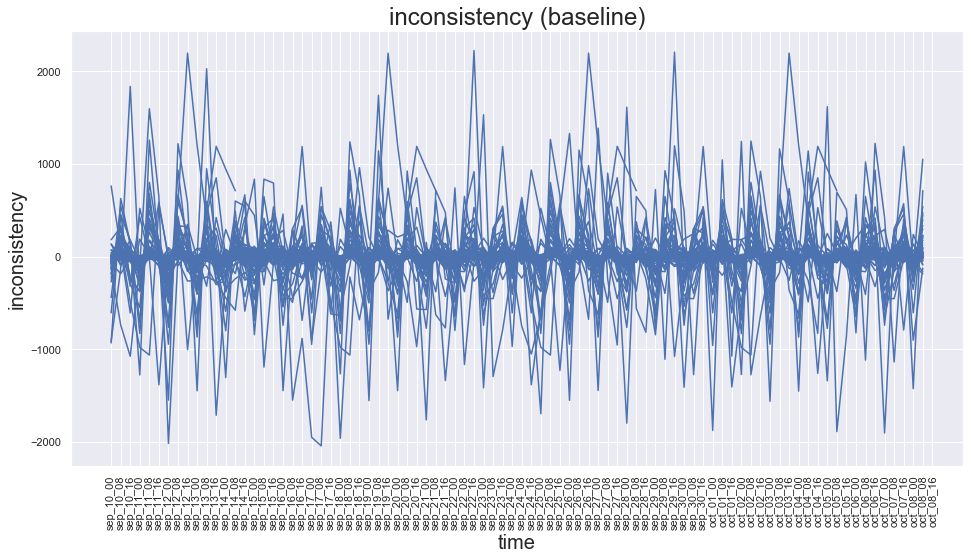

In [207]:
plt.figure(figsize=(16,8))
for i in df_inconsistency_b.index:
    plt.plot(time_span[1:], df_inconsistency_b.loc[i], color='b')
plt.xticks(range(len(time_span)), time_span, rotation=90)
plt.xlabel('time', size=20)
plt.ylabel('inconsistency', size=20)
plt.title('inconsistency (baseline)', size=24)
plt.show()

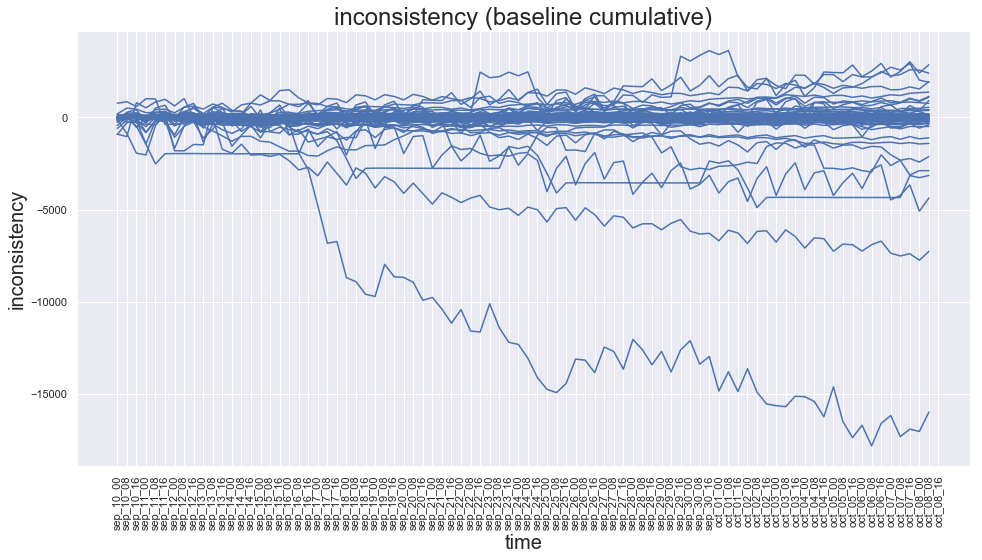

In [208]:
plt.figure(figsize=(16,8))
for i in df_inconsistency_b.index:
    if pd.isnull(df_inconsistency_b.cumsum(axis=1).loc[i]).any()==False:
        plt.plot(time_span[1:], df_inconsistency_b.cumsum(axis=1).loc[i], color='b')
plt.xticks(range(len(time_span)), time_span, rotation=90)
plt.xlabel('time', size=20)
plt.ylabel('inconsistency', size=20)
plt.title('inconsistency (baseline cumulative)', size=24)
plt.show()

In [209]:
df_inconsistency_b[(df_inconsistency_b.max(axis=1)>2000)|(df_inconsistency_b.min(axis=1)<-2000)]

sep_10_08  sep_10_16  sep_11_00  sep_11_08  sep_11_16  \
Charleston_2           -913.0     -133.8     1836.4     -272.4      311.2   
Myrtle Beach           -130.6     -738.2    -1076.6      -97.4     1595.2   
North Charleston_1     -132.3      337.9     -232.4     -373.0      619.0   

                    sep_12_00  sep_12_08  sep_12_16    sep_13_00    sep_13_08  \
Charleston_2           144.65    -355.00     396.25 -1004.275490     8.600000   
Myrtle Beach           650.40   -2016.75      -7.25   347.300000   -22.800000   
North Charleston_1    -104.00    -500.25     588.00  2195.964833  1203.173659   

                      ...      oct_05_16  oct_06_00  oct_06_08  oct_06_16  \
Charleston_2          ...         -378.0      383.4     -136.4       14.8   
Myrtle Beach          ...        -1889.2     -862.6      670.0    -1118.0   
North Charleston_1    ...            NaN        NaN        NaN        NaN   

                     oct_07_00  oct_07_08  oct_07_16  oct_08_00  oct_08_08  \
Charleston_2         225.32549      292.4     -149.4      355.6     -902.6   
Myrtle Beach        1222.00000      421.4    -1137.4      399.6     -123.6   
North Charleston_1         NaN     -449.9     -454.2      -27.7     -132.3   

                    oct_08_16  
Charleston_2           -123.4  
Myrtle Beach           1050.8  
North Charleston_1      337.9  

[3 rows x 86 columns]

In [266]:
df_inconsistency_b.shape

(240, 86)

In [210]:
df_inconsistency_b.cumsum(axis=1)[(df_inconsistency_b.cumsum(axis=1).max(axis=1)>2000)|(df_inconsistency_b.cumsum(axis=1).min(axis=1)<-2000)]

sep_10_08    sep_10_16    sep_11_00    sep_11_08  \
Charleston_2       -913.000000 -1046.800000   789.600000   517.200000   
Dover_2            -113.400000     9.600000  -480.188107 -1460.325722   
Kitty Hawk          181.400000   497.121569   439.000000   250.200000   
Myrtle Beach       -130.600000  -868.800000 -1945.400000 -2042.800000   
Norfolk_3          -607.466667  -158.600000    18.533333  -812.666667   
North Charleston_1 -132.300000   205.600000   -26.800000  -399.800000   
North Charleston_2 -191.066667   108.200000  -129.600000  -508.000000   
Summerville_1       762.200000   845.000000   578.200000  1006.200000   
Virginia Beach_3   -932.600000  -305.600000  -165.400000 -1443.200000   
Wilmington_2       -442.800000    15.000000  -278.200000  -829.000000   
Wilmington_3               NaN          NaN          NaN          NaN   

                      sep_11_16    sep_12_00    sep_12_08    sep_12_16  \
Charleston_2         828.400000   973.050000   618.050000  1014.300000   
Dover_2            -2523.500476 -1977.098416 -1966.848416 -1966.848416   
Kitty Hawk           257.721569   274.050000    39.800000    -0.700000   
Myrtle Beach        -447.600000   202.800000 -1813.950000 -1821.200000   
Norfolk_3           -220.266667  -140.566667 -1086.316667  -485.566667   
North Charleston_1   219.200000   115.200000  -385.050000   202.950000   
North Charleston_2    -8.133333    53.800000  -370.616667    65.383333   
Summerville_1        995.600000  -388.600000  -378.350000  -348.600000   
Virginia Beach_3    -186.000000  -135.900000 -1685.150000  -467.150000   
Wilmington_2        -147.000000  -238.600000  -954.600000   -19.850000   
Wilmington_3                NaN          NaN          NaN          NaN   

                      sep_13_00    sep_13_08      ...          oct_05_16  \
Charleston_2          10.024510    18.624510      ...        1934.374510   
Dover_2            -1966.848416 -1972.348416      ...       -4349.298416   
Kitty Hawk          -264.750000  -521.150000      ...        1594.483333   
Myrtle Beach       -1473.900000 -1496.700000      ...      -16504.800000   
Norfolk_3           -250.533333 -1119.933333      ...        2411.609342   
North Charleston_1  2398.914833  3602.088492      ...                NaN   
North Charleston_2   -83.183333  -378.983333      ...       -1507.233333   
Summerville_1       -231.500000  -269.100000      ...       -2832.050000   
Virginia Beach_3     116.250000 -1332.550000      ...       -3545.100000   
Wilmington_2          45.816667  -580.516667      ...       -6878.366667   
Wilmington_3                NaN  -666.200000      ...       10722.487444   

                       oct_06_00     oct_06_08     oct_06_16     oct_07_00  \
Charleston_2         2317.774510   2181.374510   2196.174510   2421.500000   
Dover_2             -4349.298416  -4349.298416  -4349.298416  -4349.298416   
Kitty Hawk           1628.883333   1829.283333   2168.283333   2475.283333   
Myrtle Beach       -17367.400000 -16697.400000 -17815.400000 -16593.400000   
Norfolk_3            2837.533333   2199.533333   2506.333333   2922.533333   
North Charleston_1           NaN           NaN           NaN           NaN   
North Charleston_2  -1497.233333  -1702.433333  -1576.033333  -1602.633333   
Summerville_1       -2741.850000  -2893.650000  -2969.250000  -2035.450000   
Virginia Beach_3    -3036.300000  -3859.900000  -2838.700000  -2576.700000   
Wilmington_2        -6908.966667  -7252.566667  -6907.366667  -6712.966667   
Wilmington_3                 NaN           NaN           NaN           NaN   

                       oct_07_08     oct_07_16     oct_08_00     oct_08_08  \
Charleston_2         2713.900000   2564.500000   2920.100000   2017.500000   
Dover_2             -4349.298416  -4349.298416  -3161.400000  -3274.800000   
Kitty Hawk           2248.404902   2313.683333   2579.083333   2553.683333   
Myrtle Beach       -16172.000000 -17309.400000 -16909.800000 -17033.400000   
Norfolk_3      

(array([ 4., 16.,  3.,  6.,  1.,  0., 15., 17., 14., 10.]),
 array([-1904.2, -1587.4, -1270.6,  -953.8,  -637. ,  -320.2,    -3.4,
          313.4,   630.2,   947. ,  1263.8]),
 <a list of 10 Patch objects>)

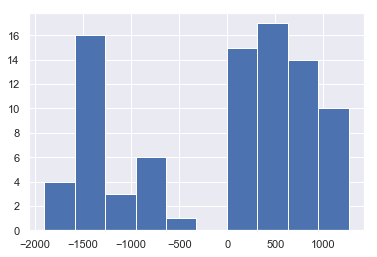

In [211]:
plt.hist(df_inconsistency_b.loc['Virginia Beach_3'])

(array([ 4.,  1.,  4.,  2.,  9., 28., 25.,  6.,  1.,  6.]),
 array([-1384.2  , -1147.595,  -910.99 ,  -674.385,  -437.78 ,  -201.175,
           35.43 ,   272.035,   508.64 ,   745.245,   981.85 ]),
 <a list of 10 Patch objects>)

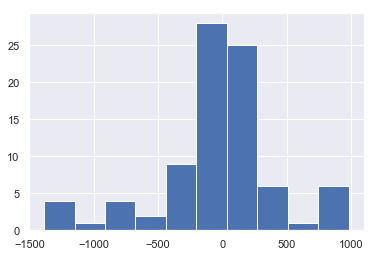

In [212]:
plt.hist(df_inconsistency_b.loc['Summerville_1'])

(array([ 1.,  0.,  0.,  6., 19., 18., 15.,  8., 14.,  5.]),
 array([-1712.46666667, -1447.745     , -1183.02333333,  -918.30166667,
         -653.58      ,  -388.85833333,  -124.13666667,   140.585     ,
          405.30666667,   670.02833333,   934.75      ]),
 <a list of 10 Patch objects>)

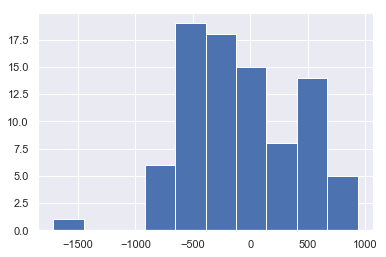

In [213]:
plt.hist(df_inconsistency_b.loc['Wilmington_2'])

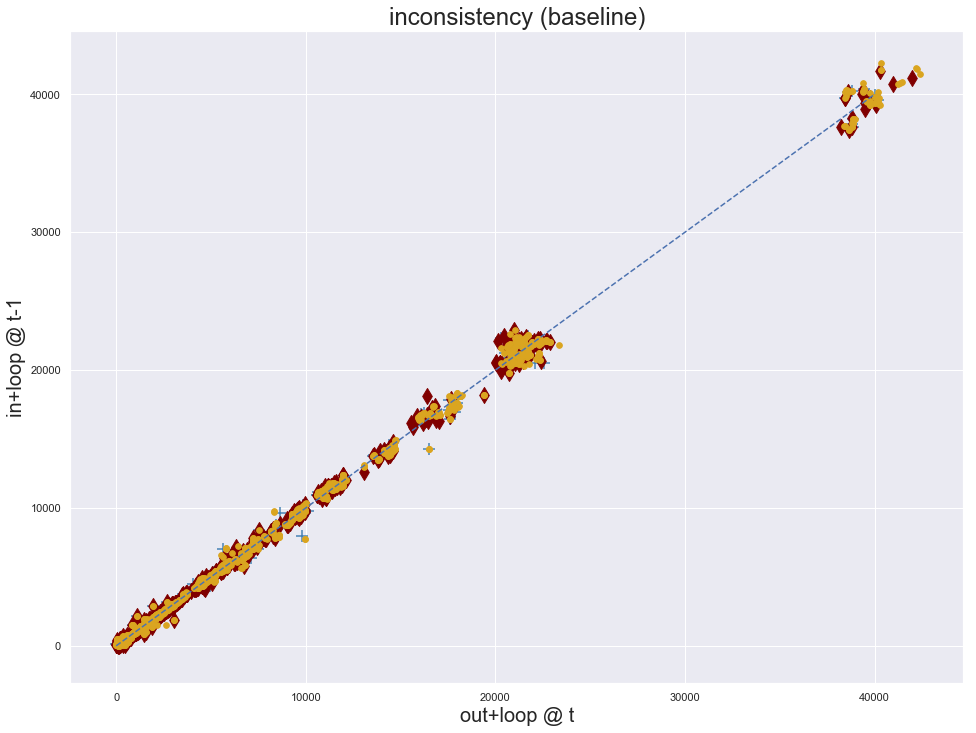

In [214]:
plt.figure(figsize=(16,12))
shape={'before Florence':'+', 'during Florence':'d', 'after Florence':'.'}
color={'before Florence':'steelblue', 'during Florence':'maroon', 'after Florence':'goldenrod'}
for i in range(1, len(time_span)):
    if time_span[i] in florence:
        label='during Florence'
    elif time_span[i] in before:
        label='before Florence'
    else:
        label='after Florence'
    plt.scatter(df_out_incl_loop_b[time_span[i]], df_in_incl_loop_b[time_span[i-1]], marker=shape[label], s=128, color=color[label])
plt.plot([0, 40000], [0, 40000], '--')
plt.xlabel('out+loop @ t', size=20)
plt.ylabel('in+loop @ t-1', size=20)
plt.title('inconsistency (baseline)', size=24)
#plt.legend(('+', 'd', '.d'), ('before Florence', 'during Florence', 'after Florence'))
plt.show()

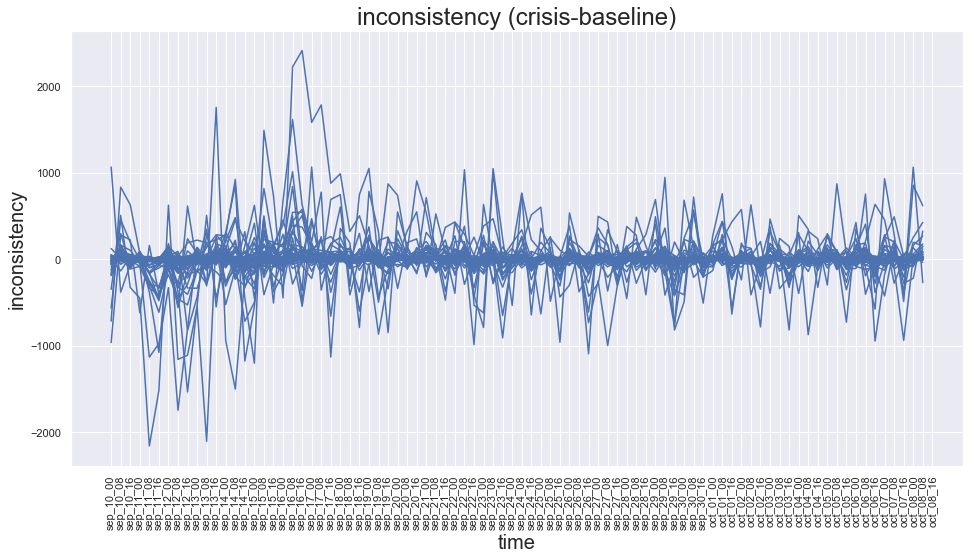

In [216]:
plt.figure(figsize=(16,8))
for i in df_inconsistency_b.index:
    if pd.isnull((df_inconsistency - df_inconsistency_b).cumsum(axis=1).loc[i]).any()==False:
        plt.plot(time_span[1:], (df_inconsistency - df_inconsistency_b).loc[i], color='b')
plt.xticks(range(len(time_span)), time_span, rotation=90)
plt.xlabel('time', size=20)
plt.ylabel('inconsistency', size=20)
plt.title('inconsistency (crisis-baseline)', size=24)
plt.show()

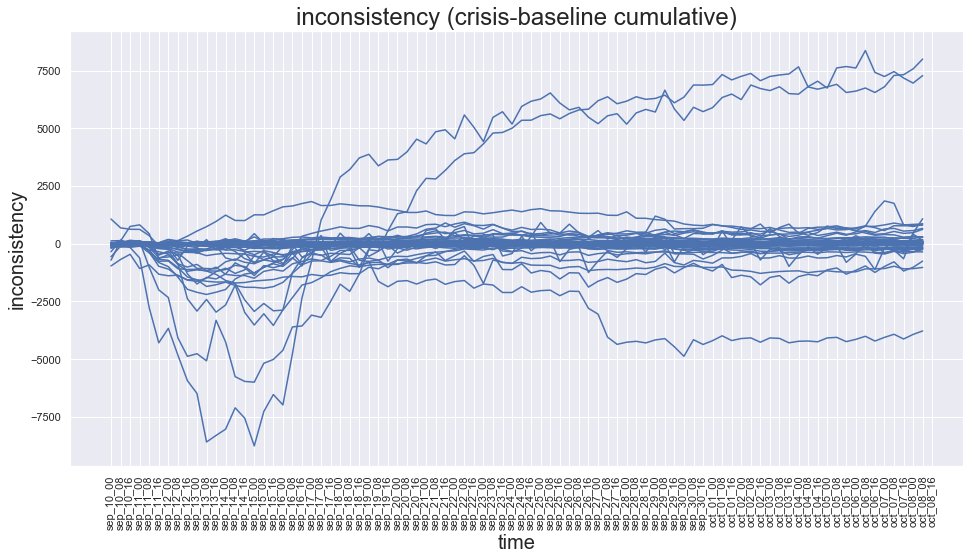

In [217]:
plt.figure(figsize=(16,8))
for i in df_inconsistency_b.index:
    if pd.isnull((df_inconsistency - df_inconsistency_b).cumsum(axis=1).loc[i]).any()==False:
        plt.plot(time_span[1:], (df_inconsistency - df_inconsistency_b).cumsum(axis=1).loc[i], color='b')
plt.xticks(range(len(time_span)), time_span, rotation=90)
plt.xlabel('time', size=20)
plt.ylabel('inconsistency', size=20)
plt.title('inconsistency (crisis-baseline cumulative)', size=24)
plt.show()

In [111]:
df_inconsistency_unbiased.cumsum(axis=1)[df_inconsistency_unbiased.cumsum(axis=1).max(axis=1)>2000]

sep_10_08  sep_10_16   sep_11_00    sep_11_08  \
Johns Island_2      -90.000000      -51.2   90.333333   379.800000   
Myrtle Beach       -347.400000      159.8 -165.600000  -616.200000   
Norfolk_3          -279.533333     -135.4  270.466667  1684.666667   
North Charleston_2  -81.933333      125.8  599.600000  1214.000000   
Wilmington_2       -117.200000       46.0  149.200000   104.000000   

                      sep_11_16  sep_12_00  sep_12_08  sep_12_16    sep_13_00  \
Johns Island_2       452.066667        NaN        NaN        NaN          NaN   
Myrtle Beach       -2774.400000    -4292.8   -3667.05   -4824.80 -5934.100000   
Norfolk_3           1675.266667        NaN        NaN        NaN          NaN   
North Charleston_2   950.133333        NaN        NaN        NaN          NaN   
Wilmington_2       -1028.000000    -2002.4   -2330.40   -4076.15 -4879.816667   

                      sep_13_08     ...         oct_05_16    oct_06_00  \
Johns Island_2       442.266667     ...       3166.500000  3148.500000   
Myrtle Beach       -6484.300000     ...       7614.800000  7674.400000   
Norfolk_3                   NaN     ...       8720.514649          NaN   
North Charleston_2   814.933333     ...        341.916667   143.916667   
Wilmington_2       -4765.483333     ...       6903.366667  6549.966667   

                      oct_06_08    oct_06_16    oct_07_00    oct_07_08  \
Johns Island_2      3221.700000  3240.700000  3208.900000  3201.700000   
Myrtle Beach        7611.400000  8366.400000  7419.400000  7243.000000   
Norfolk_3                   NaN          NaN          NaN          NaN   
North Charleston_2   260.116667   446.716667   340.316667   311.716667   
Wilmington_2        6610.566667  6744.366667  6550.966667  6797.566667   

                      oct_07_16    oct_08_00    oct_08_08    oct_08_16  
Johns Island_2      3281.800000  3238.500000  3139.500000  3144.300000  
Myrtle Beach        7455.400000  7177.800000  6957.400000  7282.600000  
Norfolk_3                   NaN          NaN          NaN          NaN  
North Charleston_2   594.116667   411.150000   480.216667   704.950000  
Wilmington_2        7289.366667  7320.166667  7571.966667  7998.366667  

[5 rows x 86 columns]

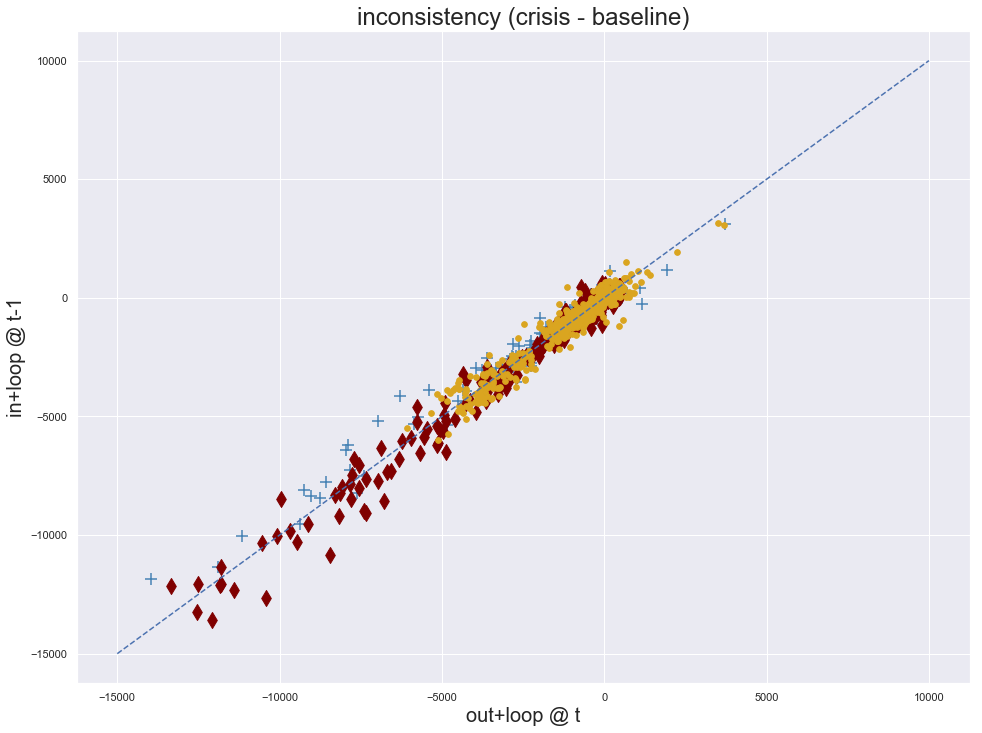

In [218]:
plt.figure(figsize=(16,12))
shape={'before Florence':'+', 'during Florence':'d', 'after Florence':'.'}
color={'before Florence':'steelblue', 'during Florence':'maroon', 'after Florence':'goldenrod'}
for i in range(1, len(time_span)):
    if time_span[i] in florence:
        label='during Florence'
    elif time_span[i] in before:
        label='before Florence'
    else:
        label='after Florence'
    plt.scatter((df_out_incl_loop-df_out_incl_loop_b)[time_span[i]], (df_in_incl_loop-df_in_incl_loop_b)[time_span[i-1]], marker=shape[label], s=128, color=color[label])
plt.plot([-15000, 10000], [-15000, 10000], '--')
plt.xlabel('out+loop @ t', size=20)
plt.ylabel('in+loop @ t-1', size=20)
plt.title('inconsistency (crisis - baseline)', size=24)
#plt.legend(('+', 'd', '.d'), ('before Florence', 'during Florence', 'after Florence'))
plt.show()

## Mandatory evacuation

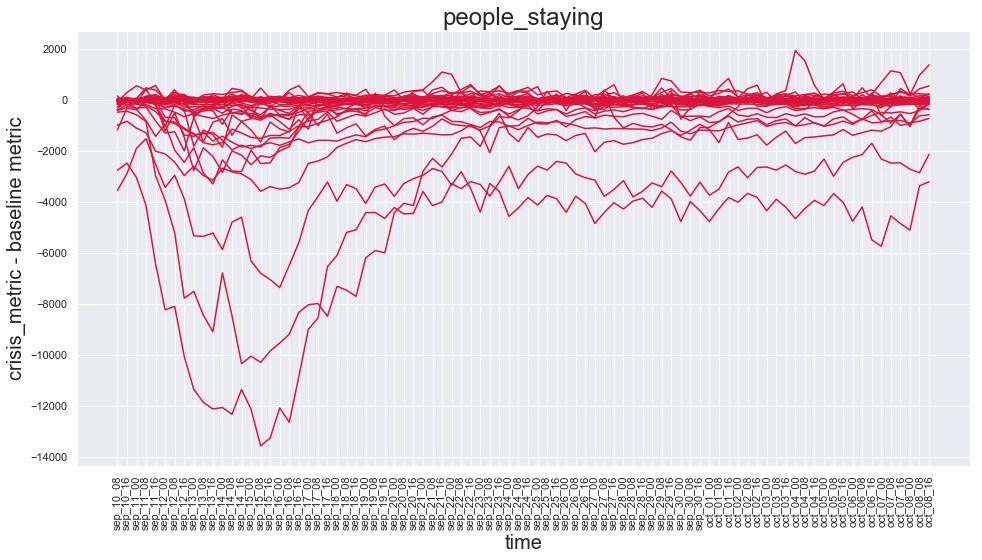

In [255]:
df_mandatory = time_evolution(cities=mandatory, metric='in_degree_incl_loops', time_span=time_span, how='d', 
                    lower_bound=None, upper_bound=None, cut_off_metric='in_degree_incl_loops', avoid_zero_division=1)

# df_inconsistency_unbiased = df_inconsistency# - df_inconsistency_b
# df_inconsistency_power = df_inconsistency_unbiased.copy()
# df_inconsistency_power[before[1:]] = 0
# df_mandatory =  df_mandatory.iloc[:, 1:] - df_inconsistency_power.cumsum(axis=1)
draw_time_evolution(df_mandatory, 'people_staying', time_span=time_span[1:], option='d')

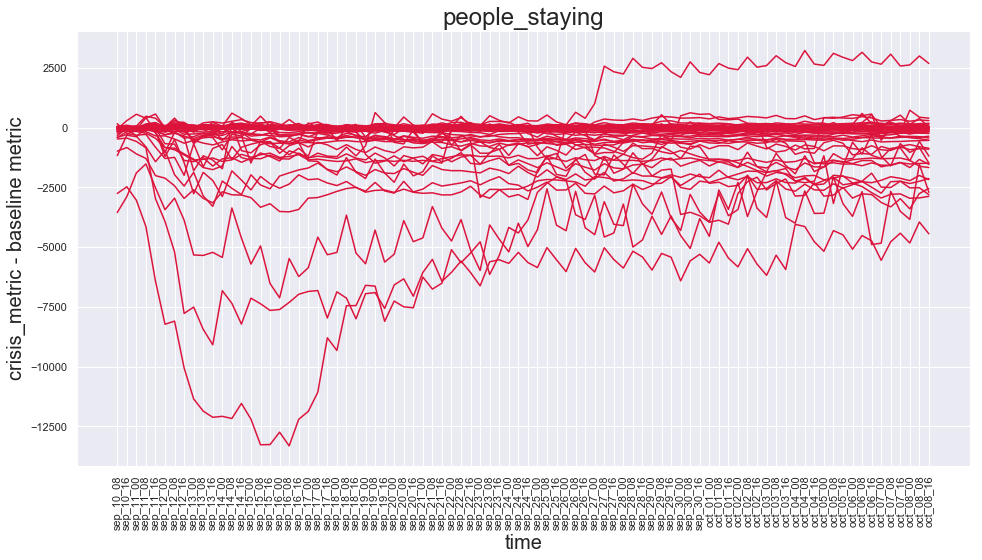

In [259]:
df_mandatory = time_evolution(cities=mandatory, metric='in_degree_incl_loops', time_span=time_span, how='d', 
                    lower_bound=None, upper_bound=None, cut_off_metric='in_degree_incl_loops', avoid_zero_division=1)

df_inconsistency_unbiased = df_inconsistency# - df_inconsistency_b
df_inconsistency_power = df_inconsistency_unbiased.copy()
df_inconsistency_power[before[1:]] = 0
df_mandatory =  df_mandatory.iloc[:, 1:] - df_inconsistency_power.cumsum(axis=1)
draw_time_evolution(df_mandatory, 'people_staying', time_span=time_span[1:], option='d')

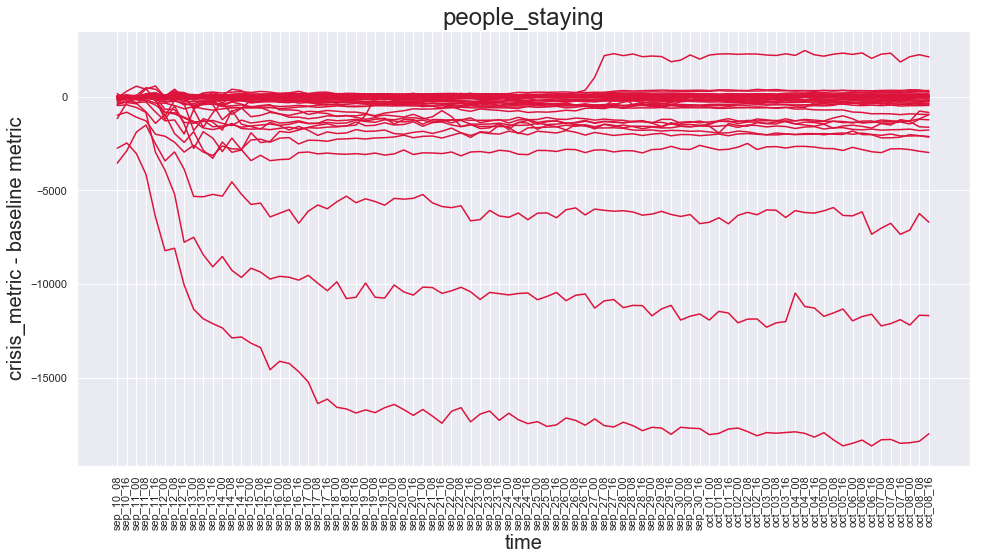

In [249]:
df_mandatory = time_evolution(cities=mandatory, metric='in_degree_incl_loops', time_span=time_span, how='d', 
                    lower_bound=None, upper_bound=None, cut_off_metric='in_degree_incl_loops', avoid_zero_division=1)

df_inconsistency_unbiased = df_inconsistency - df_inconsistency_b
df_inconsistency_power = df_inconsistency_unbiased.copy()
df_inconsistency_power[before[1:]] = 0
df_mandatory =  df_mandatory.iloc[:, 1:] - df_inconsistency_power.cumsum(axis=1)
draw_time_evolution(df_mandatory, 'people_staying', time_span=time_span[1:], option='d')

In [250]:
df_mandatory[df_mandatory.max(axis=1)>1000].dropna()

sep_10_08  sep_10_16  sep_11_00  sep_11_08  sep_11_16   sep_12_00  \
Hampton_5     -413.0     -175.8     -162.6     -237.2     -450.2 -838.666667   

           sep_12_08  sep_12_16    sep_13_00    sep_13_08     ...       \
Hampton_5     -864.0   -1104.75 -1321.133333 -1673.066667     ...        

             oct_05_16    oct_06_00    oct_06_08    oct_06_16    oct_07_00  \
Hampton_5  2319.633333  2252.433333  2331.433333  2040.033333  2263.033333   

             oct_07_08    oct_07_16    oct_08_00    oct_08_08    oct_08_16  
Hampton_5  2316.833333  1847.233333  2128.833333  2235.433333  2118.633333  

[1 rows x 86 columns]

In [248]:
evacuation.loc['Hampton_5']

country                  USA
county        Hampton (City)
state                     VA
lon                 -76.3451
lat                  37.0278
evacuation         mandatory
Name: Hampton_5, dtype: object

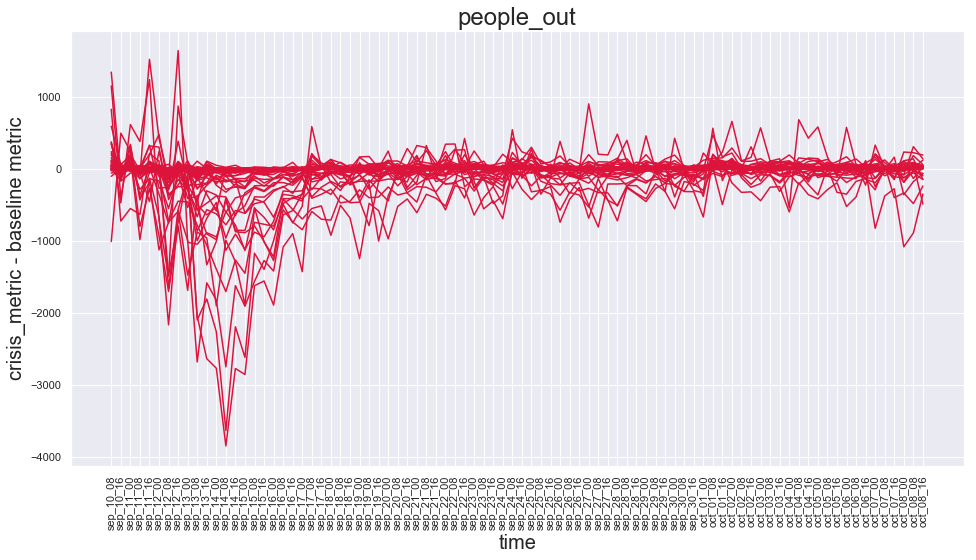

In [244]:
df_mandatory_moving = time_evolution(cities=mandatory, metric='out_degree', time_span=time_span, how='d', 
                    lower_bound=None, upper_bound=None, cut_off_metric='out_degree', avoid_zero_division=1)
df_inconsistency_move = df_inconsistency_unbiased.copy()
df_inconsistency_move[time_span[1:]] = 0
df_inconsistency_move[before[1:]] = df_inconsistency_unbiased[before[1:]]
df_mandatory_moving =  df_mandatory_moving.iloc[:, 1:] - df_inconsistency_move
draw_time_evolution(df_mandatory_moving, 'people_out', time_span=time_span[1:], option='d')

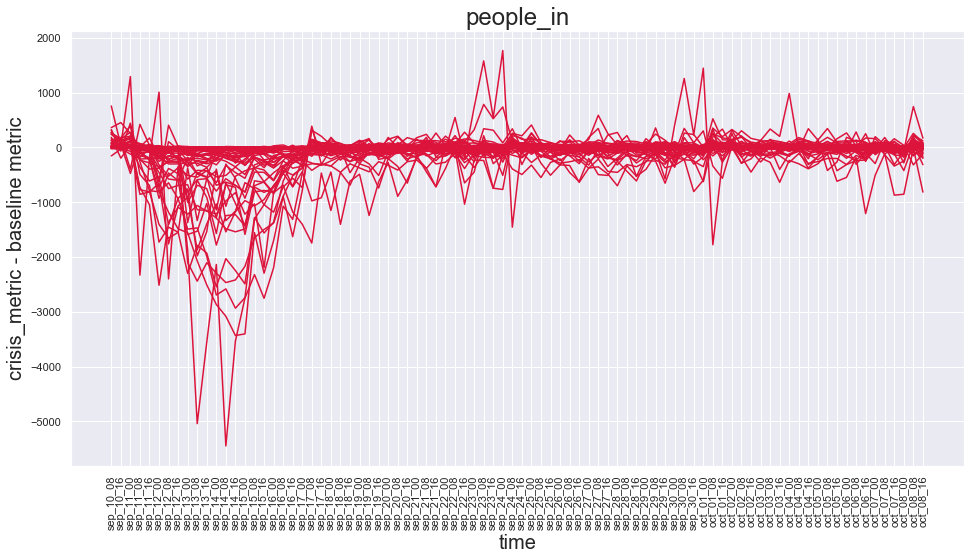

In [245]:
df_mandatory_coming = time_evolution(cities=mandatory, metric='in_degree', time_span=time_span, how='d', 
                    lower_bound=None, upper_bound=None, cut_off_metric='in_degree', avoid_zero_division=1)
#df_mandatory_coming =  df_mandatory_coming.iloc[:, 1:] - df_inconsistency_move
draw_time_evolution(df_mandatory_coming, 'people_in', time_span=time_span[1:], option='d')

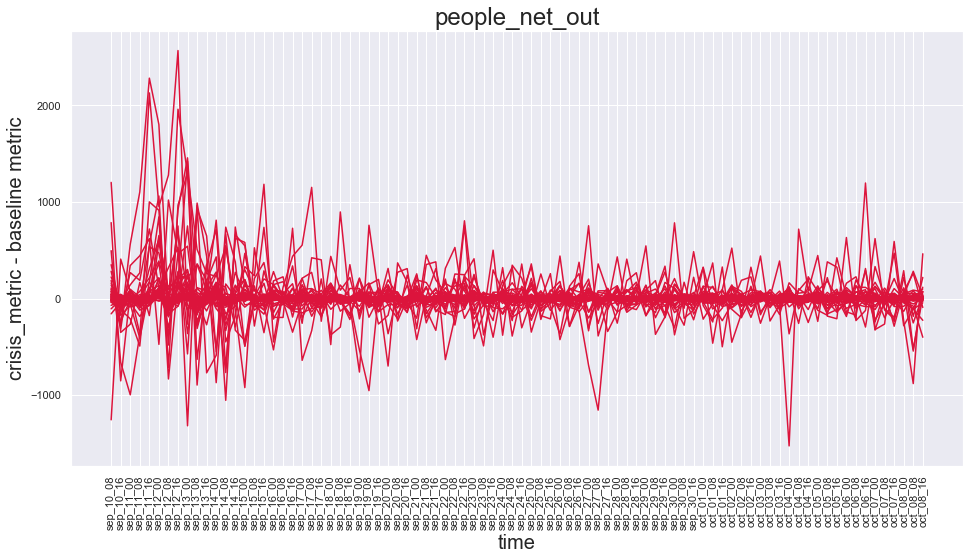

In [246]:
draw_time_evolution(df_mandatory_moving-df_mandatory_coming, 'people_net_out', time_span=time_span[1:], option='d')

## Voluntary evacuation

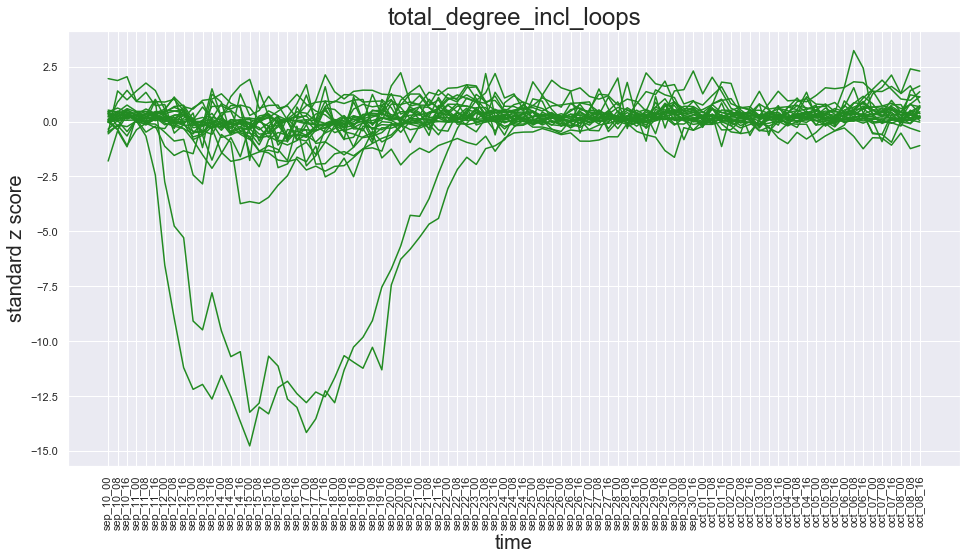

In [644]:
df_voluntary = time_evolution(cities=voluntary, metric='total_degree_incl_loops', time_span=time_span, how='z', 
                    lower_bound=None, upper_bound=None, cut_off_metric='total_degree_incl_loops', avoid_zero_division=1)
draw_time_evolution(df_voluntary, 'total_degree_incl_loops', option='z', color='forestgreen')

## Mandatory evacuation cancelled

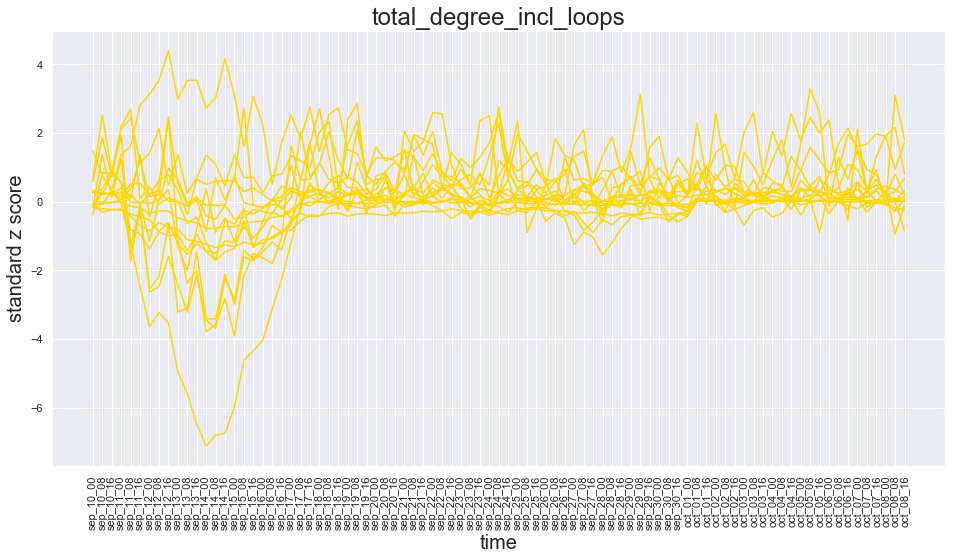

In [650]:
df_cancel = time_evolution(cities=mandatory_cancel, metric='total_degree_incl_loops', time_span=time_span, how='z', 
                    lower_bound=None, upper_bound=None, cut_off_metric='total_degree_incl_loops', avoid_zero_division=1)
draw_time_evolution(df_cancel, 'total_degree_incl_loops', option='z', color='gold')

## PCA

PCA projection could visualize the mismatch of cities in each group. For example, a mandatory group may fall into the cluster of no evacuation group.

The mismatching is common in the plot below. Many evacuated cities do not show evacuation behaviors as expected and many no-evacuation cities do fall beyong the main cluster of no-evacuation. They either were affected by Florence and evacuated as well, or they received many refugees of hurricane from the coastal cities. Further research is needed to study the reasons behind.

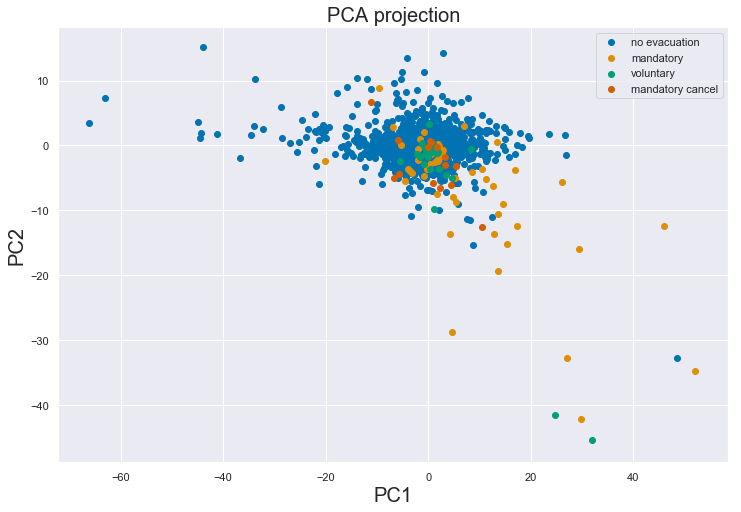

In [662]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_std = False)
df_scale = scaler.fit_transform(df_truncated.dropna(axis=0))
pca = PCA(n_components=0.8, svd_solver='full')
pca.fit(df_scale)
df_trans = pca.transform(scaler.transform(df[df.max(axis=1)<10].dropna()))

df_trans_mandatory = pca.transform(scaler.transform(df_mandatory.dropna()))
df_trans_voluntary = pca.transform(scaler.transform(df_voluntary.dropna()))
df_trans_cancel = pca.transform(scaler.transform(df_cancel.dropna()))

sns.set_palette('colorblind')
plt.figure(figsize=(12,8))
plt.scatter(df_trans[:,0], df_trans[:,1], label='no evacuation')
plt.scatter(df_trans_mandatory[:,0], df_trans_mandatory[:,1], label='mandatory')
plt.scatter(df_trans_voluntary[:,0], df_trans_voluntary[:,1], label='voluntary')
plt.scatter(df_trans_cancel[:,0], df_trans_cancel[:,1], label='mandatory cancel')
plt.xlabel('PC1', size=20)
plt.ylabel('PC2', size=20)
plt.title('PCA projection', size=20)
#plt.xlim([-50, 50])
plt.legend()
plt.show()

In [689]:
pca.explained_variance_ratio_

array([0.42604803, 0.07633719, 0.03479265, 0.02604226, 0.02434125,
       0.02041177, 0.01695715, 0.01488605, 0.0145708 , 0.01321149,
       0.01210347, 0.0115943 , 0.01093547, 0.0105061 , 0.01004094,
       0.00875393, 0.00857713, 0.00813675, 0.00774238, 0.00737439,
       0.00736333, 0.0070855 , 0.0069071 , 0.00685043, 0.00654026,
       0.00614282])

In [638]:
np.argwhere(df_trans<-800)

array([[1334,    0]])

In [641]:
df.dropna().iloc[[1334]]

sep_10_00  sep_10_08   sep_10_16  sep_11_00  sep_11_08   sep_11_16  \
Oakland  50.700983  89.264369  115.425015  89.647351  86.995934  118.577255   

         sep_12_00  sep_12_08   sep_12_16  sep_13_00     ...       oct_05_16  \
Oakland  96.297989  94.051649  122.370255  94.743964     ...      125.235258   

          oct_06_00  oct_06_08   oct_06_16  oct_07_00  oct_07_08   oct_07_16  \
Oakland  114.835812   92.62283  106.292357  98.397027  91.267661  100.223559   

         oct_08_00  oct_08_08   oct_08_16  
Oakland  90.472236  90.678458  120.197566  

[1 rows x 87 columns]

### An interactive plot

In [669]:
df_pca = pd.concat([pd.DataFrame(df_trans, index=df[df.max(axis=1)<10].dropna().index, columns=['pc'+str(i) for i in range(pca.n_components_)]),
pd.DataFrame(df_trans_mandatory, index=df_mandatory.dropna().index, columns=['pc'+str(i) for i in range(pca.n_components_)]),
pd.DataFrame(df_trans_voluntary, index=df_voluntary.dropna().index, columns=['pc'+str(i) for i in range(pca.n_components_)]),
pd.DataFrame(df_trans_cancel, index=df_cancel.dropna().index, columns=['pc'+str(i) for i in range(pca.n_components_)])])

In [672]:
df_pca['evacuation']=['no evacuation']*df_trans.shape[0]+['mandatory']*df_trans_mandatory.shape[0]+['voluntary']*df_trans_voluntary.shape[0] + ['cancel']*df_trans_cancel.shape[0]

In [677]:
df_pca = df_pca.reset_index()

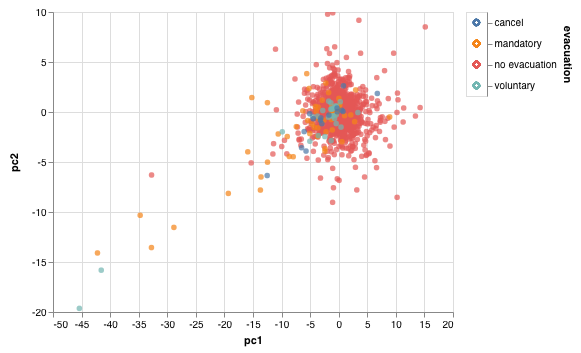

In [686]:
brush = alt.selection_interval(bind='scales')
selection = alt.selection_multi(on='mouseover', fields=['evacuation'])
color = alt.condition(selection,
                      alt.Color('evacuation:N', legend=None),
                      alt.value('lightgray'))
scatter = alt.Chart(df_pca).mark_circle().encode(
x='pc1:Q',
y='pc2:Q',
color=color,
tooltip='index:N'
).add_selection(
    brush
)

legend = alt.Chart(df_pca).mark_point().encode(
    y=alt.Y('evacuation:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selection
)

scatter | legend

In [691]:
(scatter | legend).save('pca.html')